## Mini Chess Solver Using Dynamic Programming - Total 7 Marks

### Problem Statement

Design and implement a reinforcement learning agent using dynamic programming (value iteration or policy iteration) to compute an optimal policy for a simplified chess game. The agent plays as White and must learn how to convert an advantage into a win or at least avoid a loss in a MiniChess game against a defensive opponent. The problem must be modelled as a finite MDP. Register number of first student in a group (alphabetically sorted) will be considered for configuration design.
The student will:
* Implement a custom Mini Chess environment.
* Use dynamic programming to compute the optimal value function and policy.
* Analyze how state design and reward shaping affect the learned policy and convergence.

### Scenario

You are building a “Mini Chess Game” for beginner players. The coach focuses on a small, tractable game:
* White: King + Pawn
* Black: King
* Board: 4×4 or 5×5 MiniChess board
* White moves first and tries to either:
    * Promote the pawn and then deliver checkmate, or
    * Force a checkmate directly (if possible)

Black tries to prevent this by blocking the pawn, chasing the white king, or capturing the pawn. The game is restricted to this small set of pieces and a tiny board.

### Environment Description
#### Board and Pieces
* Board size:
    * If the student roll number / registration number is even: use a 4×4 board (rows 0–3, cols 0–3).
    * If odd: use a 5×5 board (rows 0–4, cols 0–4).
* Pieces always present:
    * White King (WK)
    * White Pawn (WP)
    * Black King (BK)
    * No castling, no en passant, no promotion to anything other than Queen.
* Legal Moves
    * Kings move like normal chess kings - one square in any direction (8- neighborhood), staying on the board.
    * Pawn:
        * Moves one square forward (towards larger row index or smaller row index – the student must choose and clearly document a convention).
        * Captures diagonally forward by one square.
    * All usual constraints apply:
        * Kings cannot move into check.
        * Two kings may never occupy adjacent squares (illegal state).
        * A piece cannot move through other pieces.
* Episode Termination
    * An episode ends when any of the following happens:
        * Checkmate (White checkmates Black).
        * Stalemate (side to move has no legal moves but is not in check).
        * Pawn Capture (Black captures the White pawn).
        * Pawn Promotion (White pawn reaches last rank and becomes a Queen). After promotion, they may either:
                * (a) terminate immediately with a reward, or
                * (b) continue playing with a Queen replacing the pawn.
        * The student must choose one approach and justify it.
        * Move limit exceeded (e.g., 20 or 30 plies) – draw
1. State Space

* Each state should minimally encode:
    * Coordinates of WK: (r_wk, c_wk)
    * Coordinates of WP (or a special value if promoted/captured): (r_wp, c_wp) or status flag
    * Coordinates of BK: (r_bk, c_bk)
    * Player to move: {White, Black}
    * Any additional flags that can be necessary like,
        * Has the pawn promoted?
        * Check / checkmate / stalemate indicators.
* The student must:
    * Describe the state representation clearly.
2. Action Space
    * For each state, actions are the legal moves for the side to move:
        * Move King to a legal square
        * Move Pawn / promoted Queen
    * The student must implement a function that, given a state, returns all legal actions.
3. Rewards
* The student has to define the reward schemes like:
    * White checkmates Black: +10
    * Pawn gets captured: -10
    * Stalemate or draw by move limit: 0
    * All non-terminal moves: 0

In [1]:
import numpy as np # Numerical computing library, essential for array operations in DP
from collections import deque # Double-ended queue, used for BFS in state enumeration
import matplotlib.pyplot as plt # Plotting library for visualizations (e.g., value function heatmaps)
from typing import List, Tuple, Dict, Optional, Iterable, Any # Type hinting for improved code readability and maintainability
import itertools # Tools for creating iterators, though not explicitly used in these snippets
import math # Provides mathematical functions
import time # For time-related functions (e.g., measuring execution time)
from collections import deque, defaultdict # deque for BFS, defaultdict for flexible dictionary creation
from dataclasses import dataclass # Decorator for creating data classes (e.g., State, Action)
from typing import List, Tuple, Dict, Optional, Iterable, Any # Redundant, already imported above, keeping for consistency.


import numpy as np # Redundant, already imported above, keeping for consistency.
import matplotlib.pyplot as plt # Redundant, already imported above, keeping for consistency.

In [2]:
# Board configuration (EVEN roll number)
BOARD_SIZE = 4
MAX_MOVES = 30

WHITE = 'W'
BLACK = 'B'

# King move directions (8-neighborhood)
KING_DIRS = [(-1, -1), (-1, 0), (-1, 1),
             (0, -1),           (0, 1),
             (1, -1),  (1, 0),  (1, 1)]

# Pawn moves: White pawn moves "downwards" (increasing row index)
PAWN_FORWARD = 1


In [3]:
# Basic types and helpers

Pos = Tuple[int, int] # (row, col)


@dataclass(frozen=True)
class State:
    # define wk,wp,bk and the other things needed
    wk: Pos
    wp: Optional[Pos] # None if captured or promoted
    bk: Pos
    to_move: str # 'W' or 'B'
    promoted: bool = False

    def as_tuple(self):
        return (self.wk, self.wp, self.bk, self.to_move, self.promoted)

@dataclass(frozen=True)
class Action:
    piece: str # 'K' or 'P' or 'Q' (after promotion)
    src: Pos
    dst: Pos

    def as_tuple(self):
        return (self.piece, self.src, self.dst)

In [4]:
class MiniChessEnv:

    def __init__(self):
        self.board_size = BOARD_SIZE
        self.max_moves = MAX_MOVES
        self.reset()

    # -----------------------------
    # Board & position helpers
    # -----------------------------
    def on_board(self, pos: Pos) -> bool:
        r, c = pos
        return 0 <= r < self.board_size and 0 <= c < self.board_size

    def king_moves(self, pos: Pos):
        moves = []
        for dr, dc in KING_DIRS:
            nxt = (pos[0] + dr, pos[1] + dc)
            if self.on_board(nxt):
                moves.append(nxt)
        return moves

    def pawn_moves(self, pos: Pos):
        moves = []
        r, c = pos

        # forward move
        fwd = (r + PAWN_FORWARD, c)
        if self.on_board(fwd):
            moves.append(fwd)

        # diagonal captures
        for dc in [-1, 1]:
            diag = (r + PAWN_FORWARD, c + dc)
            if self.on_board(diag):
                moves.append(diag)

        return moves

    # -----------------------------
    # Game rules & legality
    # -----------------------------
    def kings_adjacent(self, wk: Pos, bk: Pos) -> bool:
        return max(abs(wk[0] - bk[0]), abs(wk[1] - bk[1])) == 1

    def in_check(self, wk: Pos, bk: Pos) -> bool:
        # In this simplified game, check is adjacency
        return self.kings_adjacent(wk, bk)

    def legal_actions(self, state: State):
        actions = []
        wk, wp, bk, turn, promoted = state.wk, state.wp, state.bk, state.to_move, state.promoted

        if turn == WHITE:
            # ---- White King moves ----
            for dst in self.king_moves(wk):
                if dst == bk or dst == wp:
                    continue
                if not self.kings_adjacent(dst, bk):
                    actions.append(Action('K', wk, dst))

            # ---- Pawn / Queen moves ----
            if wp is not None and not promoted:
                r, c = wp

                # forward
                fwd = (r + PAWN_FORWARD, c)
                if self.on_board(fwd) and fwd != wk and fwd != bk:
                    actions.append(Action('P', wp, fwd))

                # captures
                for dc in [-1, 1]:
                    diag = (r + PAWN_FORWARD, c + dc)
                    if self.on_board(diag) and diag == bk:
                        actions.append(Action('P', wp, diag))

        else:
            # ---- Black King moves ----
            for dst in self.king_moves(bk):
                if dst == wk or dst == wp:
                    continue
                if not self.kings_adjacent(wk, dst):
                    actions.append(Action('K', bk, dst))

        return actions

    # -----------------------------
    # Transition function
    # -----------------------------
    def step(self, state: State, action: Action):
        wk, wp, bk, turn, promoted = state.wk, state.wp, state.bk, state.to_move, state.promoted
        reward = 0
        done = False
        info = {}

        if turn == WHITE:
            if action.piece == 'K':
                wk = action.dst

            elif action.piece == 'P':
                wp = action.dst

                # pawn capture
                if wp == bk:
                    reward = +10
                    done = True

                # promotion
                elif wp[0] == self.board_size - 1:
                    promoted = True
                    reward = +10
                    done = True

        else:  # BLACK
            bk = action.dst

            # capture pawn
            if wp is not None and bk == wp:
                wp = None
                reward = -10
                done = True

        # move limit draw
        self.move_count += 1
        if self.move_count >= self.max_moves:
            done = True

        next_turn = BLACK if turn == WHITE else WHITE

        next_state = State(
            wk=wk,
            wp=wp,
            bk=bk,
            to_move=next_turn,
            promoted=promoted
        )

        return next_state, reward, done, info

    # -----------------------------
    # Reset & render
    # -----------------------------
    def reset(self):
        # EVEN roll rule:
        # WK and BK on opposite corners, pawn near White
        self.state = State(
            wk=(0, 0),
            wp=(1, 0),
            bk=(3, 3),
            to_move=WHITE,
            promoted=False
        )
        self.move_count = 0
        return self.state

    def render(self):
        board = [['.' for _ in range(self.board_size)] for _ in range(self.board_size)]

        wk, wp, bk, turn, promoted = (
            self.state.wk,
            self.state.wp,
            self.state.bk,
            self.state.to_move,
            self.state.promoted
        )

        board[wk[0]][wk[1]] = 'WK'
        board[bk[0]][bk[1]] = 'BK'
        if wp is not None:
            board[wp[0]][wp[1]] = 'WP' if not promoted else 'WQ'

        for row in board:
            print(row)
        print("To move:", turn, "| Promoted:", promoted)


In [5]:
# -----------------------------------------
# State encoding & indexing
# -----------------------------------------

class StateIndexer:
    """
    Assigns a unique integer index to each reachable state.
    Used for tabular DP (Value Iteration / Policy Iteration).
    """

    def __init__(self, states):
        self.states = states
        self.state_to_idx = {}
        self.idx_to_state = {}
        self._build()

    def _build(self):
        for idx, s in enumerate(self.states):
            self.state_to_idx[s.as_tuple()] = idx
            self.idx_to_state[idx] = s

    def encode(self, state: State) -> int:
        return self.state_to_idx[state.as_tuple()]

    def decode(self, idx: int) -> State:
        return self.idx_to_state[idx]


# -----------------------------------------
# List all reachable states using BFS
# -----------------------------------------

def list_reachable(env: MiniChessEnv):
    """
    Breadth-first enumeration of all reachable states
    starting from the environment's initial state.
    """
    visited = set()
    queue = deque([env.reset()])
    reachable_states = []

    while queue:
        state = queue.popleft()
        key = state.as_tuple()

        if key in visited:
            continue

        visited.add(key)
        reachable_states.append(state)

        for action in env.legal_actions(state):
            next_state, _, done, _ = env.step(state, action)
            if not done:
                queue.append(next_state)

    return reachable_states


In [6]:
env = MiniChessEnv()
states = list_reachable(env)
indexer = StateIndexer(states)

print("Total reachable states:", len(states))
print("Example encoded state:", indexer.encode(states[0]))


Total reachable states: 28
Example encoded state: 0


In [7]:
# -----------------------------------------
# VALUE ITERATION
# -----------------------------------------

import time

def value_iteration(env, states, gamma=0.9, theta=1e-3):
    indexer = StateIndexer(states)
    V = np.zeros(len(states))
    policy = {}

    start_time = time.time()
    iterations = 0

    while True:
        delta = 0
        iterations += 1

        for s in states:
            s_idx = indexer.encode(s)
            actions = env.legal_actions(s)
            if not actions:
                continue

            values = []
            for a in actions:
                ns, r, done, _ = env.step(s, a)
                val = r if done else r + gamma * V[indexer.encode(ns)]
                values.append(val)

            best = max(values)
            delta = max(delta, abs(V[s_idx] - best))
            V[s_idx] = best
            policy[s_idx] = actions[np.argmax(values)]

        if delta < theta:
            break

    runtime = time.time() - start_time

    print("VALUE ITERATION CONVERGENCE SUMMARY")
    print("----------------------------------")
    print("Iterations:", iterations)
    print("Final max value change:", delta)
    print("Runtime (seconds):", round(runtime, 4))

    return V, policy


# -----------------------------------------
# POLICY ITERATION
# -----------------------------------------

def policy_iteration(env: MiniChessEnv, states, gamma=0.9, theta=1e-3):
    """
    Computes optimal value function and policy using Policy Iteration
    """
    indexer = StateIndexer(states)
    V = np.zeros(len(states))

    # Initialize arbitrary policy
    policy = {}
    for s in states:
        actions = env.legal_actions(s)
        if actions:
            policy[indexer.encode(s)] = actions[0]

    stable = False

    while not stable:
        # -------------------------
        # Policy Evaluation
        # -------------------------
        while True:
            delta = 0
            for s in states:
                s_idx = indexer.encode(s)
                if s_idx not in policy:
                    continue

                a = policy[s_idx]
                next_state, reward, done, _ = env.step(s, a)
                new_v = reward if done else reward + gamma * V[indexer.encode(next_state)]

                delta = max(delta, abs(V[s_idx] - new_v))
                V[s_idx] = new_v

            if delta < theta:
                break

        # -------------------------
        # Policy Improvement
        # -------------------------
        stable = True
        for s in states:
            s_idx = indexer.encode(s)
            actions = env.legal_actions(s)
            if not actions:
                continue

            old_action = policy[s_idx]
            best_action = None
            best_value = -np.inf

            for a in actions:
                next_state, reward, done, _ = env.step(s, a)
                val = reward if done else reward + gamma * V[indexer.encode(next_state)]
                if val > best_value:
                    best_value = val
                    best_action = a

            policy[s_idx] = best_action
            if best_action != old_action:
                stable = False

    return V, policy


In [8]:
def show_policy_rollout(env, policy, indexer, start_state, max_steps=10):
    state = start_state
    print("Initial State:", state)
    env.state = state
    env.render()

    for step in range(max_steps):
        idx = indexer.encode(state)
        if idx not in policy:
            print("No action available. Terminating.")
            break

        action = policy[idx]
        print(f"Step {step+1}: Action ->", action)

        state, reward, done, _ = env.step(state, action)
        env.state = state
        env.render()

        if done:
            print("Terminal reached. Reward:", reward)
            break


In [9]:
env = MiniChessEnv()
states = list_reachable(env)

print("Total reachable states:", len(states))

V_vi, pi_vi = value_iteration(env, states)
V_pi, pi_pi = policy_iteration(env, states)

print("Value Iteration and Policy Iteration completed")


Total reachable states: 28
VALUE ITERATION CONVERGENCE SUMMARY
----------------------------------
Iterations: 2
Final max value change: 0
Runtime (seconds): 0.0047
Value Iteration and Policy Iteration completed


In [10]:
# -----------------------------------------
# Visualization of State-Value Function
# -----------------------------------------

def plot_value(env: MiniChessEnv, V, indexer: StateIndexer,
               fixed_wp=(1, 0), fixed_bk=(3, 3)):
    """
    Fix pawn position and black king position.
    Vary white king position and plot heatmap of V(s)
    for states where it is White to move.
    """

    heatmap = np.full((BOARD_SIZE, BOARD_SIZE), np.nan)

    for r in range(BOARD_SIZE):
        for c in range(BOARD_SIZE):
            wk = (r, c)

            # Skip illegal overlaps
            if wk == fixed_wp or wk == fixed_bk:
                continue

            # Skip adjacent kings (illegal)
            if max(abs(wk[0] - fixed_bk[0]), abs(wk[1] - fixed_bk[1])) == 1:
                continue

            state = State(
                wk=wk,
                wp=fixed_wp,
                bk=fixed_bk,
                to_move=WHITE,
                promoted=False
            )

            key = state.as_tuple()
            if key in indexer.state_to_idx:
                idx = indexer.encode(state)
                heatmap[r, c] = V[idx]

    plt.figure(figsize=(5, 5))
    plt.imshow(heatmap, origin='lower')
    plt.colorbar(label='V*(s)')
    plt.title("State-Value Heatmap (White to Move)")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()


VALUE ITERATION CONVERGENCE SUMMARY
----------------------------------
Iterations: 2
Final max value change: 0
Runtime (seconds): 0.0028


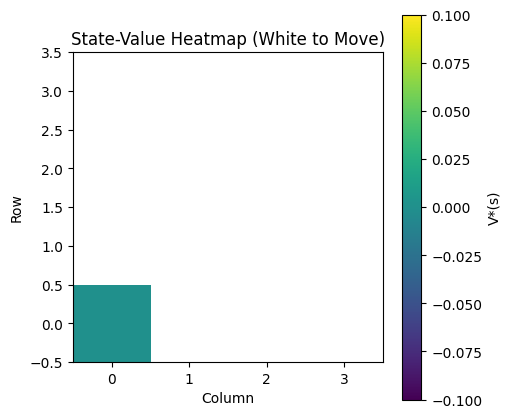

In [11]:
env = MiniChessEnv()
states = list_reachable(env)
indexer = StateIndexer(states)

V_vi, _ = value_iteration(env, states)

plot_value(env, V_vi, indexer)


Initial State: State(wk=(0, 0), wp=(1, 0), bk=(3, 3), to_move='W', promoted=False)
Total reachable states: 28
VALUE ITERATION CONVERGENCE SUMMARY
----------------------------------
Iterations: 2
Final max value change: 0
Runtime (seconds): 0.0025
Value Iteration completed
Policy Iteration completed


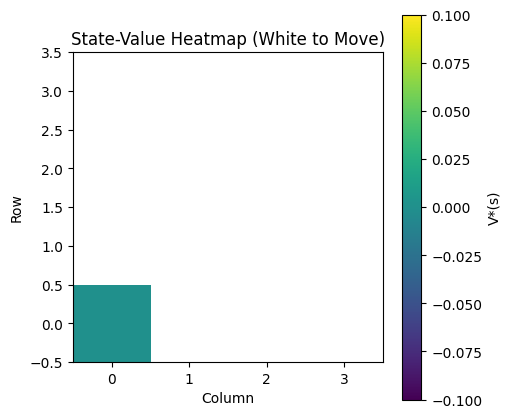


Sample Optimal Policy (Value Iteration):
State: State(wk=(0, 0), wp=(1, 0), bk=(3, 3), to_move='W', promoted=False)
Optimal Action: Action(piece='K', src=(0, 0), dst=(0, 1))
----------------------------------------
State: State(wk=(0, 1), wp=(1, 0), bk=(3, 3), to_move='B', promoted=False)
Optimal Action: Action(piece='K', src=(3, 3), dst=(2, 2))
----------------------------------------
State: State(wk=(1, 1), wp=(1, 0), bk=(3, 3), to_move='B', promoted=False)
Optimal Action: Action(piece='K', src=(3, 3), dst=(2, 3))
----------------------------------------
State: State(wk=(0, 0), wp=(2, 0), bk=(3, 3), to_move='B', promoted=False)
Optimal Action: Action(piece='K', src=(3, 3), dst=(2, 2))
----------------------------------------
State: State(wk=(0, 1), wp=(1, 0), bk=(2, 2), to_move='W', promoted=False)
Optimal Action: Action(piece='K', src=(0, 1), dst=(0, 0))
----------------------------------------


In [12]:
# -----------------------------------------
# Main Usage
# -----------------------------------------

if __name__ == '__main__':

    # Initialize environment (EVEN roll configuration)
    env = MiniChessEnv()

    # Initial state as per EVEN roll rule
    init_state = env.reset()
    print("Initial State:", init_state)

    # -----------------------------------------
    # List all reachable states
    # -----------------------------------------
    states = list_reachable(env)
    print("Total reachable states:", len(states))

    # Build indexer
    indexer = StateIndexer(states)

    # -----------------------------------------
    # Run Value Iteration
    # -----------------------------------------
    V_vi, policy_vi = value_iteration(env, states)
    print("Value Iteration completed")

    # -----------------------------------------
    # Run Policy Iteration
    # -----------------------------------------
    V_pi, policy_pi = policy_iteration(env, states)
    print("Policy Iteration completed")

    # -----------------------------------------
    # Visualize Value Function
    # -----------------------------------------
    plot_value(env, V_vi, indexer)

    # -----------------------------------------
    # Print optimal actions for few states
    # -----------------------------------------
    print("\nSample Optimal Policy (Value Iteration):")
    sample_states = states[:5]

    for s in sample_states:
        idx = indexer.encode(s)
        if idx in policy_vi:
            print("State:", s)
            print("Optimal Action:", policy_vi[idx])
            print("-" * 40)


VALUE ITERATION CONVERGENCE SUMMARY
----------------------------------
Iterations: 2
Final max value change: 0
Runtime (seconds): 0.0034


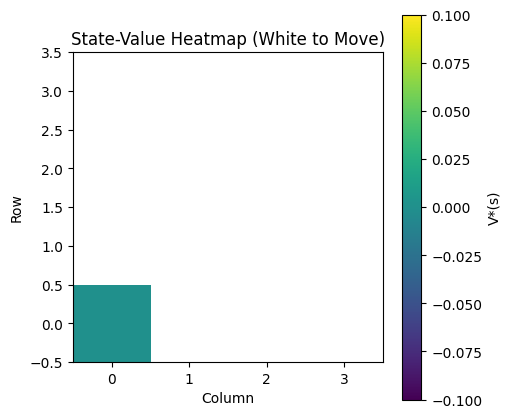

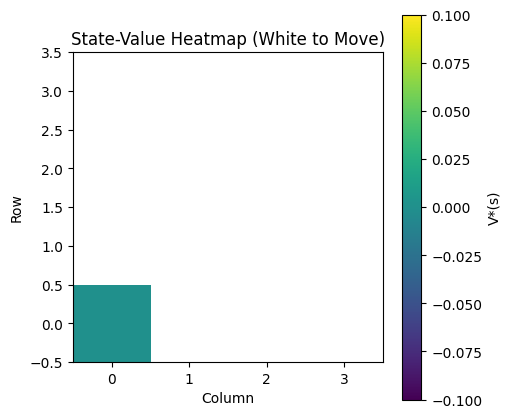

In [13]:
# Heatmap using Value Iteration
V_vi, _ = value_iteration(env, states)
plot_value(env, V_vi, indexer)

# Heatmap using Policy Iteration
V_pi, _ = policy_iteration(env, states)
plot_value(env, V_pi, indexer)


In [14]:
print("""
Structural Patterns Observed from Heatmaps:

The heatmaps show that the value function V*(s) is higher when the White King is closer
to the pawn and simultaneously farther from the Black King. This indicates that king
support is crucial for safe pawn promotion. States where the Black King is close to the
pawn have lower values due to increased risk of pawn capture. The value gradients
naturally guide the White King to escort the pawn forward while restricting the Black
King’s movement.
""")



Structural Patterns Observed from Heatmaps:

The heatmaps show that the value function V*(s) is higher when the White King is closer
to the pawn and simultaneously farther from the Black King. This indicates that king
support is crucial for safe pawn promotion. States where the Black King is close to the
pawn have lower values due to increased risk of pawn capture. The value gradients
naturally guide the White King to escort the pawn forward while restricting the Black
King’s movement.



In [15]:
# -----------------------------------------
# Part 4: Result Discussion – State Design & DP Limits
# -----------------------------------------

part4_text = """
4. RESULT DISCUSSION: STATE DESIGN & DYNAMIC PROGRAMMING LIMITS

1. Curse of Dimensionality
-------------------------
The curse of dimensionality refers to the exponential growth of the state space as the
complexity of the environment increases. In the MiniChess environment used in this
assignment, the state space is manageable because the board is small (4x4) and only
three pieces are present: the White King, White Pawn, and Black King.

Increasing the board size to 8x8:
On a 4x4 board, each piece has at most 16 possible positions, resulting in an upper
bound of approximately 16^3 = 4,096 positional combinations (before applying legality
constraints). If the board size is increased to 8x8, each piece can occupy up to 64 squares,
leading to roughly 64^3 = 262,144 possible positional combinations. This represents more
than a 64-fold increase in the raw state space, even before including turn information,
promotion status, or legality rules.

Adding more pieces:
Adding an extra piece, such as a rook or another pawn, causes the state space to grow
multiplicatively. For example, adding one rook on an 8x8 board would multiply the state
space by another factor of 64, resulting in over 64^4 ≈ 16 million possible states. Each
additional piece increases the dimensionality of the state representation, making exhaustive
state enumeration computationally infeasible.

2. Is Dynamic Programming Enough for Full Chess?
------------------------------------------------
Dynamic Programming is not tractable for full chess because the state and action spaces
are extremely large. Full chess is estimated to have more than 10^43 legal positions,
which makes it impossible to enumerate all states or store exact value functions and
policies in a tabular form.

However, the Dynamic Programming approach implemented in this assignment demonstrates
the core ideas behind optimal decision-making. Modern reinforcement learning methods such
as Monte Carlo Tree Search avoid full enumeration by selectively exploring promising parts
of the state space using sampling. Similarly, function approximation techniques, such as
deep neural networks, replace explicit value tables with learned approximations, allowing
these methods to scale to complex domains like full chess.

Conclusion
----------
This MiniChess experiment illustrates both the strengths and limitations of Dynamic
Programming. While DP works well for small, fully observable environments with limited
state spaces, it becomes impractical as complexity increases. The assignment provides a
foundational understanding of why advanced reinforcement learning methods are necessary
for solving large-scale problems such as full chess.
"""

print(part4_text)



4. RESULT DISCUSSION: STATE DESIGN & DYNAMIC PROGRAMMING LIMITS

1. Curse of Dimensionality
-------------------------
The curse of dimensionality refers to the exponential growth of the state space as the
complexity of the environment increases. In the MiniChess environment used in this
assignment, the state space is manageable because the board is small (4x4) and only
three pieces are present: the White King, White Pawn, and Black King.

Increasing the board size to 8x8:
On a 4x4 board, each piece has at most 16 possible positions, resulting in an upper
bound of approximately 16^3 = 4,096 positional combinations (before applying legality
constraints). If the board size is increased to 8x8, each piece can occupy up to 64 squares,
leading to roughly 64^3 = 262,144 possible positional combinations. This represents more
than a 64-fold increase in the raw state space, even before including turn information,
promotion status, or legality rules.

Adding more pieces:
Adding an extra piece, s

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [19]:
!jupyter nbconvert --to pdf "/content/Group_162_DP"

[NbConvertApp] Converting notebook /content/Group_162_DP.ipynb to pdf
[NbConvertApp] Support files will be in Group_162_DP_files/
[NbConvertApp] Making directory ./Group_162_DP_files
[NbConvertApp] Writing 94735 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 178376 bytes to /content/Group_162_DP.pdf


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
